# Feature Manipulation in Pandas

Here let's look at a different dataset that will allow us to really dive into some meaningful statistics. This data set is publically available, but is also part of a Kaggle competition.

You can get the data from here: https://www.kaggle.com/c/titanic-gettingStarted or you can use the code below to load the data from GitHub.

There are lots of iPython notebooks for looking at the Titanic data. Check them out and see you like any!

In [29]:
# load the Titanic dataset
import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/eclarson/DataMiningNotebooks/master/data/titanic.csv') # read in the csv file

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [30]:
df.describe()

/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [31]:
print(df.dtypes)
print(df.info())

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [32]:
# the percentage of individuals that died on the titanic
float(len(df[df.Survived==0]))/len(df)*100.0

61.61616161616161

In [33]:
# Lets aggregate by class and count survival rates
df_grouped = df.groupby(by='Pclass')
print(df_grouped.Survived.sum())
print('---------------------------------------')
print(df_grouped.Survived.count())
print('---------------------------------------')
print(df_grouped.Survived.sum() / df_grouped.Survived.count())

Pclass
1    136
2     87
3    119
Name: Survived, dtype: int64
---------------------------------------
Pclass
1    216
2    184
3    491
Name: Survived, dtype: int64
---------------------------------------
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


## Feature Discretization

In [34]:
# let's break up the age variable
df['age_range'] = pd.cut(df.Age,[0,16,65,1e6],3,labels=['child','adult','senior']) # this creates a new variable
df.age_range.describe()

count       714
unique        3
top       adult
freq        606
Name: age_range, dtype: object

In [35]:
# now lets group with the new variable
df_grouped = df.groupby(by=['Pclass','age_range'])
print ("Percentage of survivors in each group:")
print (df_grouped.Survived.sum() / df_grouped.Survived.count() *100)

Percentage of survivors in each group:
Pclass  age_range
1       child        88.888889
        adult        65.317919
        senior       25.000000
2       child        90.476190
        adult        42.666667
        senior        0.000000
3       child        40.000000
        adult        20.141343
        senior        0.000000
Name: Survived, dtype: float64


In [36]:
# let's clean the dataset a little before moving on

# 1. Remove attributes that just arent useful for us
for col in ['PassengerId','Name','Cabin','Ticket']:
    if col in df:
        del df[col]

# 2. Impute some missing values, grouped by their Pclass and SibSp numbers
df_grouped = df.groupby(by=['Pclass','SibSp'])
print (df_grouped.describe())

                           Age        Fare       Parch    Survived
Pclass SibSp                                                      
1      0     count  113.000000  137.000000  137.000000  137.000000
             mean    39.181416   75.223356    0.270073    0.562044
             std     14.844591   87.103081    0.575270    0.497956
             min      4.000000    0.000000    0.000000    0.000000
             25%           NaN   27.720800    0.000000    0.000000
             50%           NaN   39.600000    0.000000    1.000000
             75%           NaN   80.000000    0.000000    1.000000
             max     80.000000  512.329200    2.000000    1.000000
       1     count   65.000000   71.000000   71.000000   71.000000
             mean    37.414154   88.492021    0.422535    0.746479
             std     14.690355   40.307129    0.786711    0.438123
             min      0.920000   39.600000    0.000000    0.000000
             25%           NaN   56.414600    0.000000    0.50

/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


In [37]:
# now use this grouping to fill the data set in each group, then transform back
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median()))
col_deleted = df.columns - df_imputed.columns # in case the median operation deleted columns
df_imputed[col_deleted] = df[col_deleted]

print (df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived     891 non-null int64
Age          884 non-null float64
Parch        891 non-null int64
Fare         891 non-null float64
Embarked     889 non-null object
Pclass       891 non-null int64
Sex          891 non-null object
SibSp        891 non-null int64
age_range    714 non-null category
dtypes: category(1), float64(2), int64(4), object(2)
memory usage: 56.7+ KB
None


/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  app.launch_new_instance()


In [38]:
# 3. Computed discrete features agains now with the newest values
df_imputed['age_range'] = pd.cut(df_imputed.Age,[0,16,65,1e6],3,labels=['child','adult','senior']) # this creates a new variable

print (df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived     891 non-null int64
Age          884 non-null float64
Parch        891 non-null int64
Fare         891 non-null float64
Embarked     889 non-null object
Pclass       891 non-null int64
Sex          891 non-null object
SibSp        891 non-null int64
age_range    884 non-null category
dtypes: category(1), float64(2), int64(4), object(2)
memory usage: 56.7+ KB
None


In [39]:
# 4. drop rows that still had missing values after grouped imputation
df_imputed.dropna(inplace=True)

# 5. Rearrange the columns
df_imputed = df_imputed[['Survived','Age','age_range','Sex','Parch','SibSp','Pclass','Fare','Embarked']]

print (df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 0 to 890
Data columns (total 9 columns):
Survived     882 non-null int64
Age          882 non-null float64
age_range    882 non-null category
Sex          882 non-null object
Parch        882 non-null int64
SibSp        882 non-null int64
Pclass       882 non-null int64
Fare         882 non-null float64
Embarked     882 non-null object
dtypes: category(1), float64(2), int64(4), object(2)
memory usage: 62.9+ KB
None


In [40]:
# did the statistics of survival change much? Let' check by repeating the previous grouped calcualtions
df_grouped = df_imputed.groupby(by=['Pclass','age_range'])
print ("Percentage of survivors in each group, with imputed values:")
print (df_grouped.Survived.sum() / df_grouped.Survived.count() *100)

Percentage of survivors in each group, with imputed values:
Pclass  age_range
1       child        88.888889
        adult        62.189055
        senior       25.000000
2       child        90.476190
        adult        42.236025
        senior        0.000000
3       child        37.837838
        adult        22.303922
        senior        0.000000
Name: Survived, dtype: float64


# Visualization in Python with Pandas, Matplotlib, and Others

In [41]:
# this python magics will allow plot to be embedded into the notebook
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

## Visualizing the dataset

Pandas has plenty of plotting abilities built in. Let's take a look at a few of the different graphing capabilities of Pandas with only matplotlib. Afterward, we can make the visualizations more beautiful.

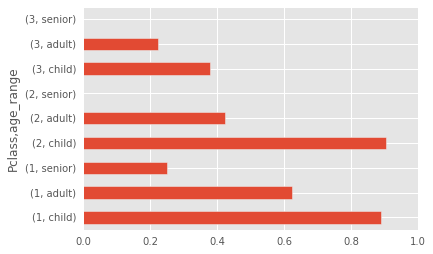

In [42]:
# Start by just plotting what we previsously grouped!
plt.style.use('ggplot')

df_grouped = df_imputed.groupby(by=['Pclass','age_range'])
survival_rate = df_grouped.Survived.sum() / df_grouped.Survived.count()
ax = survival_rate.plot(kind='barh')

Survived          False  True 
Pclass age_range              
1      child          1      8
       adult         76    125
       senior         3      1
2      child          2     19
       adult         93     68
       senior         2      0
3      child         46     28
       adult        317     91
       senior         2      0


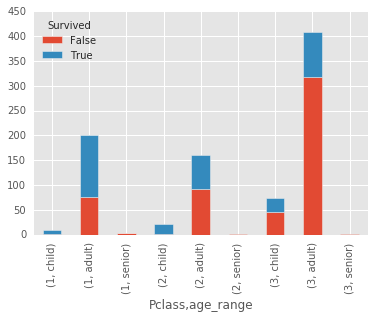

In [43]:
# the cross tab operator provides an easy way to get these numbers
survival = pd.crosstab([ df_imputed['Pclass'],df_imputed['age_range'] ], 
                       df_imputed.Survived.astype(bool))
print(survival)

survival.plot(kind='bar', 
                     stacked=True)

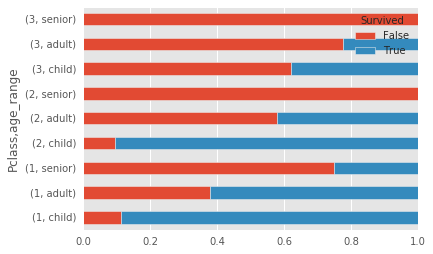

In [44]:
survival_rate = survival.div(survival.sum(1).astype(float),
                             axis=0) # normalize the value

# print survival_rate
survival_rate.plot(kind='barh', 
                   stacked=True)

/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  from ipykernel import kernelapp as app


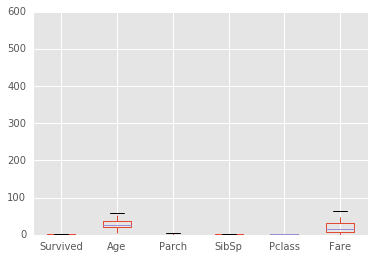

In [45]:
# pandas has some really powerful extensions to matplotlib for scientific computing 
ax = df_imputed.boxplot() # not a great plot because of the dynamic range issues

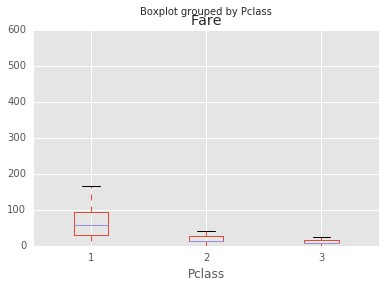

In [46]:
df_imputed.boxplot(column='Fare', by = 'Pclass') # group by class

/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


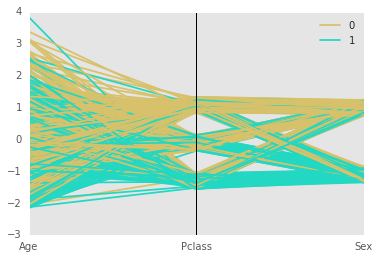

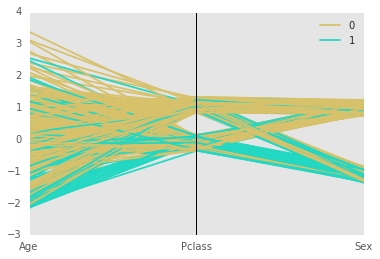

In [47]:
from pandas.tools.plotting import parallel_coordinates

# this plot is more meaningful when values are normalized
# parallel_coordinates(df_imputed[['Survived','Age','Pclass','Fare']],'Survived')

df_sub = df_imputed[['Survived','Age','Pclass','Sex']]
df_sub.Sex = df_sub.Sex=='male' 

df_normalized = (df_sub-df_sub.mean())/(df_sub.std())
df_normalized.Survived = df_sub.Survived # keep this as boolean

# add some jitter to the Pclass and Sex variables
df_normalized.Pclass = df_normalized.Pclass+np.random.rand(*df_normalized.Pclass.shape)/2
df_normalized.Sex = df_normalized.Sex+np.random.rand(*df_normalized.Sex.shape)/2


parallel_coordinates(df_normalized,'Survived')

plt.figure()
parallel_coordinates(df_normalized[df_sub.Pclass>1],'Survived')



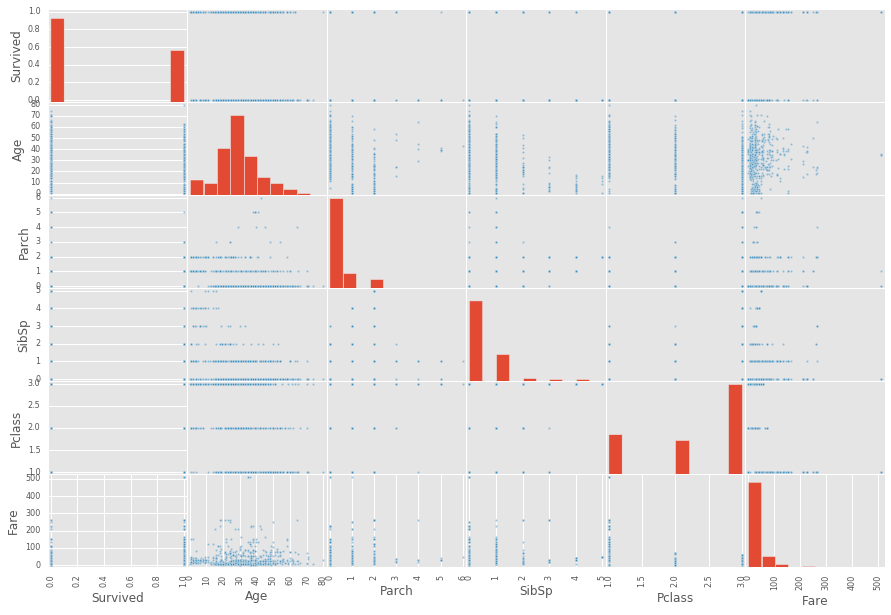

In [48]:
from pandas.tools.plotting import scatter_matrix

# not a good plot, it needs jitter to make the categorical attributes better visualized
ax = scatter_matrix(df_imputed,figsize=(15, 10))

# also we need some type of subset selection, this is just too much data

# Simplifying with Seaborn
Now let's take a look at what we get from our previous import statement: 
+ `import seaborn as sns` 


In [49]:
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

# now try plotting some of the previous plots, way more visually appealing!!

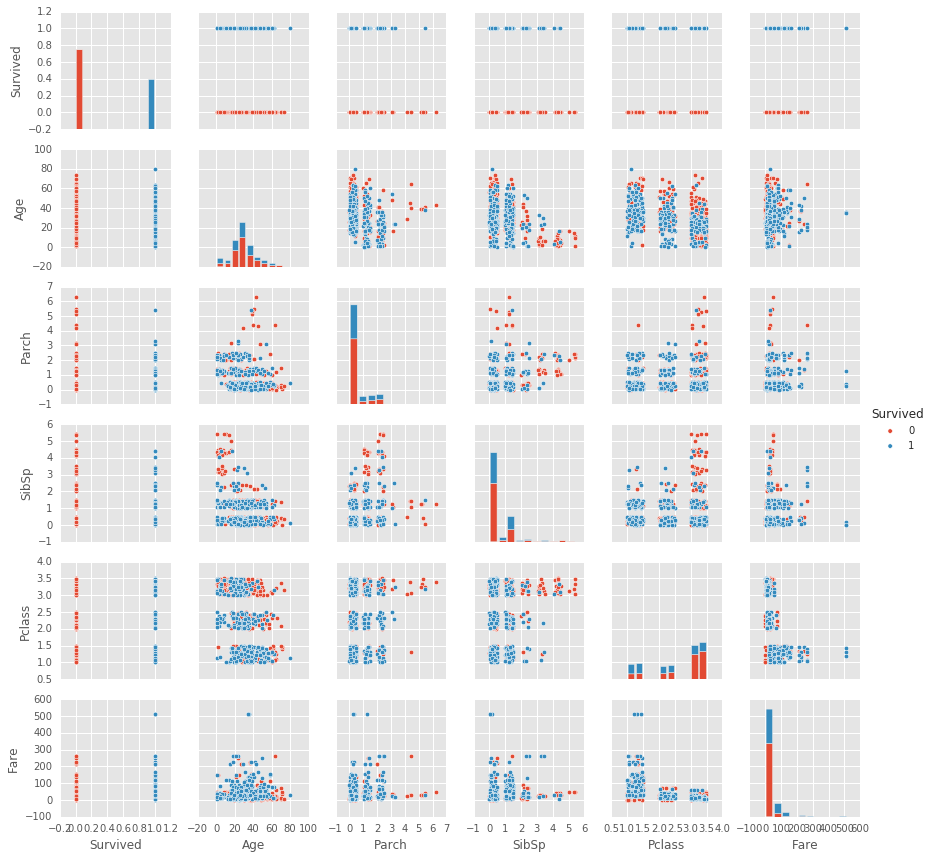

In [52]:
df_imputed_jitter = df_imputed.copy()
df_imputed_jitter[['Parch','SibSp','Pclass']] = df_imputed_jitter[['Parch','SibSp','Pclass']].values + np.random.rand(len(df_imputed_jitter),3)/2 
sns.pairplot(df_imputed_jitter, hue="Survived", size=2)

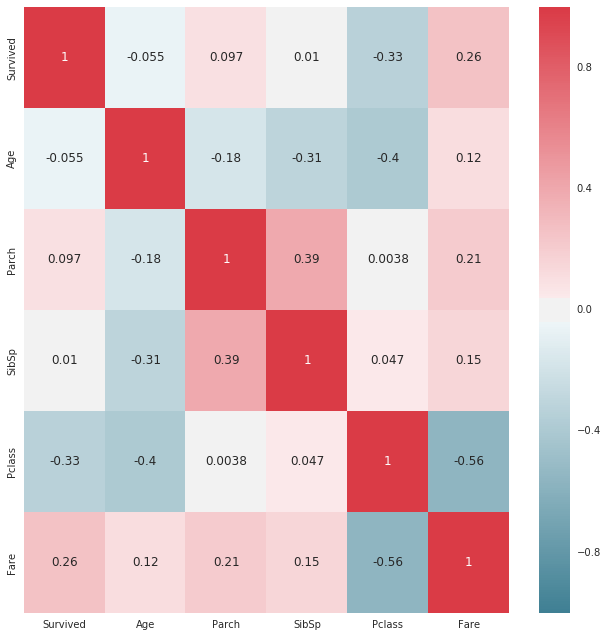

In [21]:
# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(df_imputed.corr(), cmap=cmap, annot=True)

f.tight_layout()

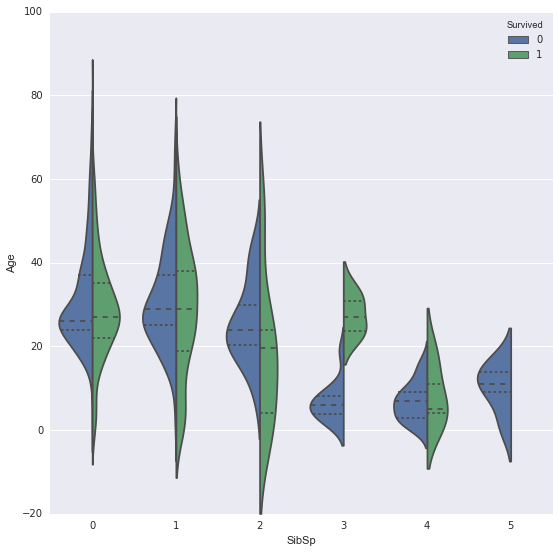

In [22]:
f, ax = plt.subplots(figsize=(9, 9))

sns.violinplot(x="SibSp", y="Age", hue="Survived", data=df_imputed, 
               split=True, inner="quart")


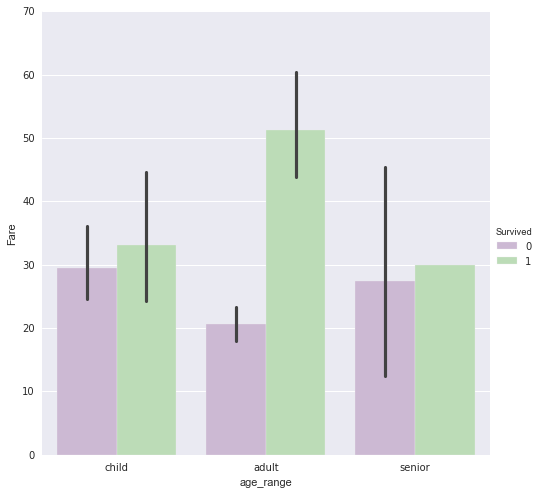

In [47]:
# this generic plotting for categorically grouped data
sns.factorplot(x='age_range',y='Fare',hue='Survived',data=df_imputed, 
               kind='bar', # other options: violin, bar, box, and others 
               palette='PRGn',
               size=7,ci=95)

# Update: Using the now open source version of Plotly
- https://plot.ly/python/getting-started/

More updates to come to this section of the notebook. Plotly is a major step in the direction of using JavaScript and python together and I would argue it has a much better implementation than other packages. 

In [48]:
# directly from the getting started example...
import plotly
print (plotly.__version__)            # version 1.9.x required
plotly.offline.init_notebook_mode() # run at the start of every notebook
plotly.offline.iplot({
    "data": [{
        "x": [1, 2, 3],
        "y": [4, 2, 5]
    }],
    "layout": {
        "title": "hello world"
    }
})

1.12.9


In [49]:
from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis
# let's manipulate the example to serve our purposes
plotly.offline.iplot({
    'data':[
        Scatter(x=df_imputed.SibSp.values+np.random.rand(*df_imputed.SibSp.shape)/5,
                y=df_imputed.Age,
                text=df_imputed.Survived.values.astype(str),
                marker=Marker(size=df_imputed.Fare, sizemode='area', sizeref=1,),
                mode='markers')
            ],
    'layout': Layout(xaxis=XAxis(title='Sibling and Spouses'), yaxis=YAxis(title='Age'))
}, show_link=False)

Visualizing more than three attributes requires a good deal of thought. In the following graph, lets use interactivity to help bolster the analysis. We will create a graph with custom text overlays that help refine the passenger we are looking at. We will 
- color code whether they survived
- Scatter plot Age and Social class
- Code the number of siblings/spouses traveling with them through the size of the marker

In [54]:
def get_text(df_row):
    return 'Age: %d<br>Class: %d<br>Fare: %.2f<br>SibSpouse: %d<br>ParChildren: %d'%(df_row.Age,df_row.Pclass,df_row.Fare,df_row.SibSp,df_row.Parch)

df_imputed['text'] = df_imputed.apply(get_text,axis=1)
textstring = ['Perished','Survived', ]

plotly.offline.iplot({
    'data': [
        Scatter(x=df_imputed.Pclass[df_imputed.Survived==val].values+np.random.rand(*df_imputed.SibSp[df_imputed.Survived==val].shape)/2,
                y=df_imputed.Age[df_imputed.Survived==val],
                text=df_imputed.text[df_imputed.Survived==val].values.astype(str),
                marker=Marker(size=df_imputed[df_imputed.Survived==val].SibSp, sizemode='area', sizeref=0.01,),
                mode='markers',
                name=textstring[val]) for val in [0,1]
    ],
    'layout': Layout(xaxis=XAxis(title='Class'), yaxis=YAxis(title='Age'),
                     title='Age and Class Scatter Plot, Size = number of siblings and spouses'),
    
}, show_link=False)

Check more about using plotly here:
- https://plot.ly/python/ipython-notebook-tutorial/ 